In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator


['bcc', 'mel', 'nv']
        lesion_id      image_id   dx    dx_type   age     sex  \
7126  HAM_0005881  ISIC_0030967   nv      histo  60.0  female   
5798  HAM_0002030  ISIC_0032916   nv      histo  55.0    male   
2706  HAM_0006874  ISIC_0025017   nv  follow_up  65.0    male   
2478  HAM_0003114  ISIC_0032091   nv  follow_up  45.0  female   
6354  HAM_0003002  ISIC_0033384   nv      histo  40.0    male   
4011  HAM_0001951  ISIC_0030216   nv  follow_up  80.0    male   
858   HAM_0000624  ISIC_0029089  mel      histo  70.0    male   
4010  HAM_0007039  ISIC_0025202   nv  follow_up  80.0    male   
5015  HAM_0000390  ISIC_0026756   nv  follow_up  30.0  female   
3801  HAM_0006582  ISIC_0029487   nv  follow_up  55.0    male   

         localization  label  
7126             foot      2  
5798             back      2  
2706  lower extremity      2  
2478             back      2  
6354  lower extremity      2  
4011          abdomen      2  
858              back      1  
4010  lower ext

C:\Users\Hp Elite Book\.conda\envs\SkinDiseaseDetectionSystem\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


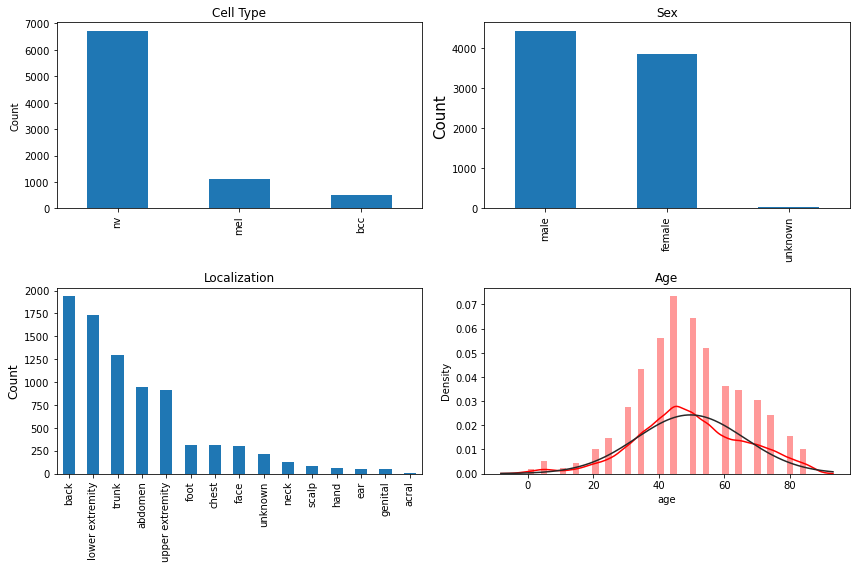

In [2]:
skin_df = pd.read_csv('E:\Dataset SDDS/Dataset/HAM10000_metadata.csv')
SIZE = 64

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [3]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)


skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                            df_2_balanced])

print(skin_df_balanced['label'].value_counts())


2    6704
1    1112
0     514
Name: label, dtype: int64
0    500
1    500
2    500
Name: label, dtype: int64


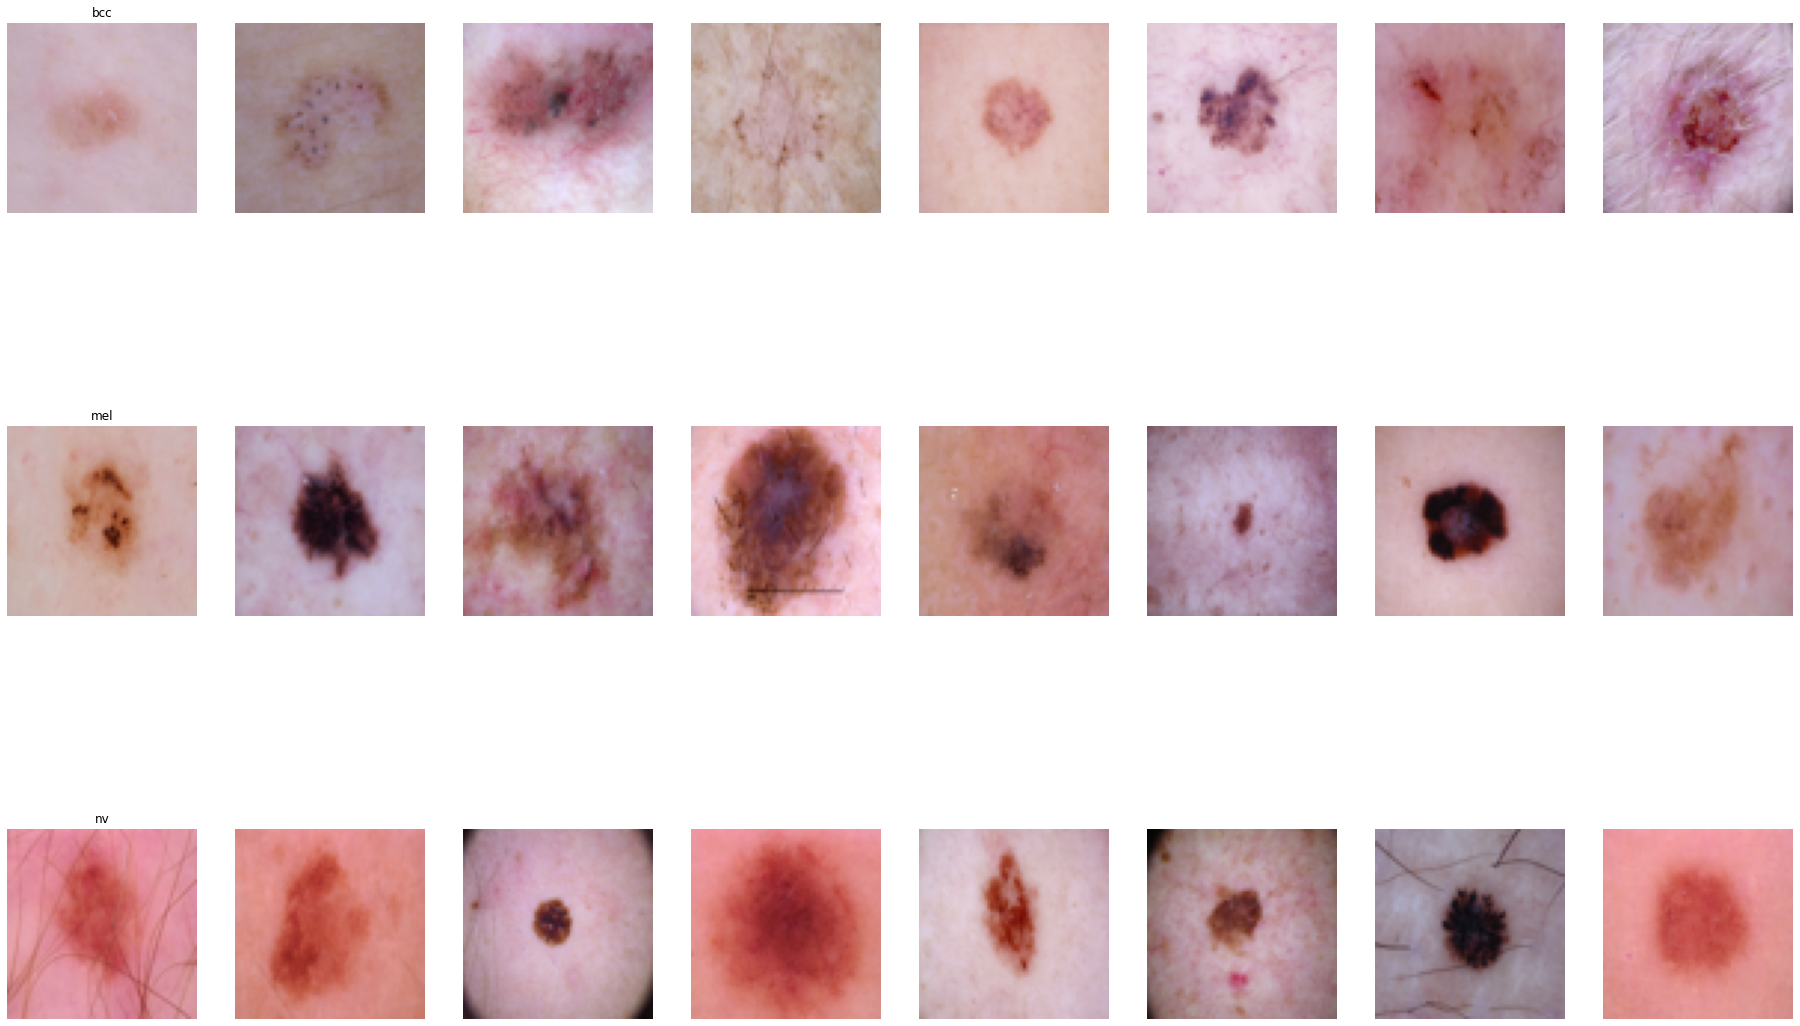

In [4]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                    for x in glob(os.path.join('E:\Dataset SDDS/Dataset/', '*', '*.jpg'))}

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

n_samples = 8

fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                        skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
        

In [5]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. 

Y=skin_df_balanced['label'] 
Y_cat = to_categorical(Y, num_classes=3) 

x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [6]:
num_classes = 3

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0